In [36]:
import pickle
import networkx as nx
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import random
import os
os.chdir("D:/uppsala/16. data of social mining/data")

In [7]:
# Load graph data
file_path_pkl = 'network_data.pkl'
with open(file_path_pkl, 'rb') as f: # 注意 'rb' (读取二进制)
    G = pickle.load(f)

In [ ]:
type(G) # 有向图

networkx.classes.multidigraph.MultiDiGraph

In [9]:
# gpt 仅仅保留最大网络？但是人家就要计算有多少个component呀，感觉不对
# G = G.subgraph(max(nx.connected_components(G), key=len)).copy()  
n = G.number_of_nodes()
m = G.number_of_edges()

# 计算 ER 模型的参数：p = 2m / (n*(n-1))
p = 2*m / (n*(n-1))
print(f"Order n={n}, Size m={m}, p={p:.6f}")

Order n=1936, Size m=23220, p=0.012397


In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def describe_graph_full(G, name="network", plot=True):
    """
    打印并返回所有要求的网络描述性统计指标
    ✅ 支持 Graph, DiGraph, MultiGraph, MultiDiGraph
    🚫 若为 MultiGraph 类型，不计算不支持的指标，仅输出提示
    """

    # === 1. 基本结构指标 ===
    n = G.number_of_nodes()        # 节点数量
    m = G.number_of_edges()        # 边数量
    density = nx.density(G)        # 网络密度

    # 判断是否有向图
    if nx.is_directed(G):
        components = nx.number_strongly_connected_components(G)
    else:
        components = nx.number_connected_components(G)

    # === 2. 聚类系数与传递性 ===
    clustering = np.nan
    transitivity = np.nan

    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        print(f"⚠️ [{name}] MultiGraph type detected — clustering and transitivity not computed.")
    else:
        try:
            clustering = nx.average_clustering(G)
            transitivity = nx.transitivity(G)
        except Exception as e:
            print(f"⚠️ [{name}] Clustering/Transitivity not computed: {e}")
            clustering = np.nan
            transitivity = np.nan

    # === 3. 度分布 ===
    if nx.is_directed(G):
        in_degrees = np.array([d for _, d in G.in_degree()])
        out_degrees = np.array([d for _, d in G.out_degree()])
        avg_in = in_degrees.mean()
        avg_out = out_degrees.mean()
        degrees = in_degrees + out_degrees
        avg_degree = degrees.mean()
    else:
        degrees = np.array([d for _, d in G.degree()])
        avg_degree = degrees.mean()
        avg_in = avg_out = np.nan

    # === 4. 打印结果 ===
    # print(f"\n📊 [{name}]")
    # print(f"Order (nodes): {n}")
    # print(f"Size (edges): {m}")
    # print(f"Number of components: {components}")
    # print(f"Density: {density:.6f}")
    # print(f"Average degree: {avg_degree:.2f}")
    # if nx.is_directed(G):
    #     print(f"  ↳ Average in-degree: {avg_in:.2f}")
    #     print(f"  ↳ Average out-degree: {avg_out:.2f}")
    # print(f"Average clustering coefficient: {clustering}")
    # print(f"Transitivity: {transitivity}")

    # === 5. 可视化度分布 ===
    if plot and len(degrees) > 0:
        plt.figure(figsize=(5,4))
        plt.hist(degrees, bins=50, color='steelblue', edgecolor='black')
        plt.title(f"Degree distribution of {name}")
        plt.xlabel("Degree")
        plt.ylabel("Count")
        plt.show()

    # === 6. 返回结果字典 ===
    return {
        "Network": name,
        "Directed": nx.is_directed(G),
        "Order (n)": n,
        "Size (m)": m,
        "Components": components,
        "Density": density,
        "Avg degree": avg_degree,
        "Avg in-degree": avg_in,
        "Avg out-degree": avg_out,
        "Clustering": clustering,
        "Transitivity": transitivity
    }


In [29]:
# 生成三张 ER 随机图 ------------------------------
er_graphs = []
for seed in [1, 2, 3]:
    H = nx.fast_gnp_random_graph(n, p, seed=seed,directed=True)
    # 保留最大连通分量
    # H = H.subgraph(max(nx.connected_components(H), key=len)).copy()
    er_graphs.append(H)

⚠️ [Real Network] MultiGraph type detected — clustering and transitivity not computed.


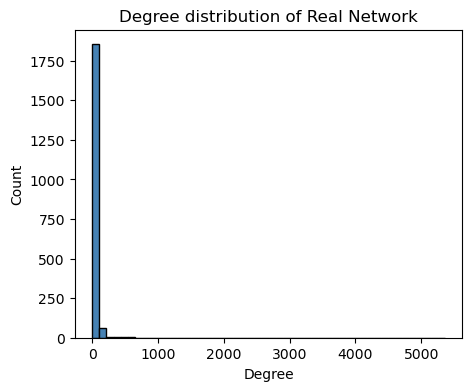

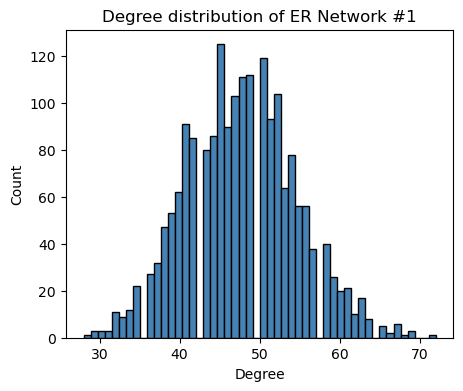

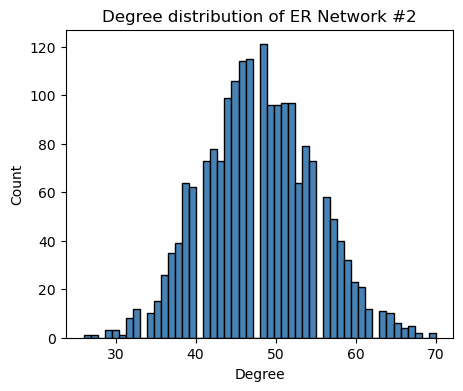

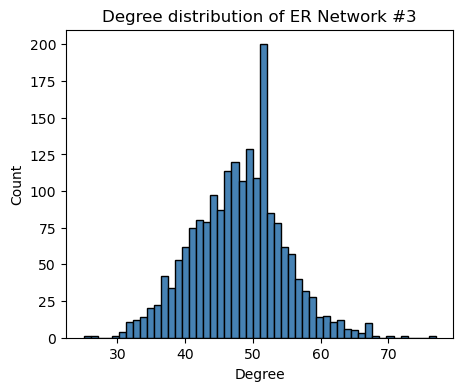

In [33]:

# 用于存放所有er网络的统计结果
results_er = []

# 1️⃣ 描述真实网络
results_er.append(describe_graph_full(G, name="Real Network"))

# 2️⃣ 描述三张 ER 网络
for i, H in enumerate(er_graphs, start=1):
    results_er.append(describe_graph_full(H, name=f"ER Network #{i}"))

In [34]:
print(pd.DataFrame(results_er) )

         Network  Directed  Order (n)  Size (m)  Components   Density  \
0   Real Network      True       1936     23220        1405  0.006198   
1  ER Network #1      True       1936     46196           1  0.012332   
2  ER Network #2      True       1936     46439           1  0.012396   
3  ER Network #3      True       1936     46288           1  0.012356   

   Avg degree  Avg in-degree  Avg out-degree  Clustering  Transitivity  
0   23.987603      11.993802       11.993802         NaN           NaN  
1   47.723140      23.861570       23.861570    0.012370      0.012324  
2   47.974174      23.987087       23.987087    0.012389      0.012339  
3   47.818182      23.909091       23.909091    0.012297      0.012212  


In [37]:
# === 提取真实网络参数 ===
n = G.number_of_nodes()
m = G.number_of_edges()
p = m / (n * (n - 1))   # ER 模型平均连接概率
avg_degree = 2 * m / n  # 平均度
m_BA = max(1, int(round(avg_degree / 2)))  # BA参数：每个新节点连接的边数

print(f"真实网络: n={n}, m={m}, p≈{p:.6f}, 平均度≈{avg_degree:.2f}, BA参数 m={m_BA}")

#  生成三张 BA 网络 ===
ba_graphs = []
for i in range(3):
    # Step 1: 生成无向 BA 图
    H = nx.barabasi_albert_graph(n=n, m=m_BA, seed=42+i)
    
    # Step 2: 转换为有向图 —— 随机指定边方向
    H_directed = nx.DiGraph()
    H_directed.add_nodes_from(H.nodes())
    for u, v in H.edges():
        if random.random() < 0.5:
            H_directed.add_edge(u, v)
        else:
            H_directed.add_edge(v, u)
    
    ba_graphs.append(H_directed)

# ===  计算描述性统计指标 ===
results_ba = []

# 真实网络
results_ba.append(describe_graph_full(G, name="Real Retweet Network", plot=False))

# 三张 BA 网络
for i, H in enumerate(ba_graphs, start=1):
    results_ba.append(describe_graph_full(H, name=f"BA Network #{i}", plot=False))

# ===  保存结果到 DataFrame ===
df_ba = pd.DataFrame(results_ba)
df_ba.to_csv("results_ba_comparison.csv", index=False)
print("\n✅ Results saved to 'results_ba_comparison.csv'")
print(df_ba)

真实网络: n=1936, m=23220, p≈0.006198, 平均度≈23.99, BA参数 m=12
⚠️ [Real Retweet Network] MultiGraph type detected — clustering and transitivity not computed.

✅ Results saved to 'results_ba_comparison.csv'
                Network  Directed  Order (n)  Size (m)  Components   Density  \
0  Real Retweet Network      True       1936     23220        1405  0.006198   
1         BA Network #1      True       1936     23088           1  0.006163   
2         BA Network #2      True       1936     23088           1  0.006163   
3         BA Network #3      True       1936     23088           1  0.006163   

   Avg degree  Avg in-degree  Avg out-degree  Clustering  Transitivity  
0   23.987603      11.993802       11.993802         NaN           NaN  
1   23.851240      11.925620       11.925620    0.020504      0.018368  
2   23.851240      11.925620       11.925620    0.021100      0.019212  
3   23.851240      11.925620       11.925620    0.022352      0.018837  


In [ ]:


def generate_directed_ws(n, k, beta, seed=None):
    """
    生成有向版 Watts–Strogatz (WS) 小世界网络。
    
    参数说明：
    ----------
    n : int
        节点数 (number of nodes)
    k : int
        每个节点初始连接的邻居数（必须为偶数）
    beta : float
        重连概率（0 表示规则环，1 表示完全随机）
    seed : int, optional
        随机种子，保证复现性

    返回：
    ----------
    DG : networkx.DiGraph
        有向小世界网络
    """

    # Step 1: 生成无向 WS 网络
    G = nx.watts_strogatz_graph(n=n, k=k, p=beta, seed=seed)

    # Step 2: 转为有向图（随机分配方向）
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes())

    rng = random.Random(seed)
    for u, v in G.edges():
        if rng.random() < 0.5:
            DG.add_edge(u, v)
        else:
            DG.add_edge(v, u)

    return DG


In [39]:

# === 2️⃣ 工具函数 ===
def to_undirected_simple(G):
    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        Gu = nx.Graph()
        Gu.add_nodes_from(G.nodes())
        Gu.add_edges_from([(u, v) for u, v, *_ in G.edges(keys=True)])
    else:
        Gu = G.to_undirected() if nx.is_directed(G) else nx.Graph(G)
    return Gu

def avg_path_length_lcc(G_undirected):
    """在最大连通子图上计算平均路径长度"""
    if G_undirected.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G_undirected):
        return nx.average_shortest_path_length(G_undirected)
    comps = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
    H = G_undirected.subgraph(comps[0]).copy()
    if H.number_of_nodes() <= 1:
        return np.nan
    return nx.average_shortest_path_length(H)

In [ ]:
# 生成3个有向 WS 网络
# === 3️⃣ 有向 WS 生成函数 ===
def generate_directed_ws(n, k, beta, seed=None):
    """生成有向版 WS 网络"""
    G = nx.watts_strogatz_graph(n=n, k=k, p=beta, seed=seed)
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes())
    rng = random.Random(seed)
    for u, v in G.edges():
        if rng.random() < 0.5:
            DG.add_edge(u, v)
        else:
            DG.add_edge(v, u)
    return DG


# === 4️⃣ 主函数：生成三张 WS 网络并比较 ===
def generate_three_ws_like_retweet(G, save_csv=True):
    # Step 1: 提取 Retweet 网络参数
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)
    Gu = to_undirected_simple(G)
    k_target = round(2 * Gu.number_of_edges() / n)
    if k_target % 2 == 1:
        k_target += 1
    C_target = nx.average_clustering(Gu)
    L_target = avg_path_length_lcc(Gu)
    print(f"Retweet network: n={n}, k≈{k_target}, C≈{C_target:.4f}, L≈{L_target:.4f}")

    # Step 2: 网格搜索 β 使 (C,L) 接近
    betas = np.linspace(0.0, 1.0, 21)
    best = {"beta": 0.1, "err": np.inf}
    for b in betas:
        C_vals, L_vals = [], []
        for s in range(2):
            Gt = nx.watts_strogatz_graph(n, k_target, b, seed=10+s)
            C_vals.append(nx.average_clustering(Gt))
            L_vals.append(avg_path_length_lcc(Gt))
        C_mean, L_mean = np.mean(C_vals), np.mean(L_vals)
        err = abs(C_mean - C_target)/C_target + abs(L_mean - L_target)/L_target
        if err < best["err"]:
            best = {"beta": b, "err": err, "C": C_mean, "L": L_mean}
    beta_opt = best["beta"]
    print(f"Chosen β={beta_opt:.3f} (C≈{best['C']:.4f}, L≈{best['L']:.4f})")

    # Step 3: 生成三张 WS（有向）
    ws_graphs = []
    for i in range(3):
        ws_graphs.append(generate_directed_ws(n, k_target, beta_opt, seed=100+i))

    # Step 4: 计算描述性统计
    results_ws = []
    results_ws.append(describe_graph_full(G, name="Real Retweet Network"))
    for i, H in enumerate(ws_graphs, 1):
        results.append(describe_graph_full(H, name=f"Directed WS Network #{i}"))

    df = pd.DataFrame(results_ws)
